# Objective: 

Experimentation is key to innovation at big tech companies. And to measure its success, there needs to be statistical rigor and not just lift in the test group.

After helping to build out v0 experimentation framework at Mercari, I wanted to dig deeper into A/B testing advancements when it comes to more rigorous and modern techniques. 

This notebook serves as a Python code application of this [Towards Data Science article](https://towardsdatascience.com/how-to-select-the-right-statistical-tests-for-different-a-b-metrics-c8a1865851e) about how experimentation was done at TikTok as well as answers to [interview questions](https://prepfully.com/interview-questions/stitch-fix/data-scientist?page=3) from Stitch Fix's Data Scientist team.

In [1]:
!pip install duckdb jupysql --quiet #dask-expr

In [2]:
# Data Maniupulation

# import dask
# dask.config.set({'dataframe.query-planning': True})
# import dask.dataframe as dd

import duckdb
%load_ext sql
conn = duckdb.connect()
%sql conn --alias duckdb 
# import dask
# dask.config.set({'dataframe.query-planning': True})
# import dask.dataframe as dd

import numpy as np
import pandas as pd

# Statistics
from scipy import stats
import scipy.stats

# Test for Normality
from scipy.stats import shapiro

# Statistical Test
from scipy.stats import mannwhitneyu

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

Deploy Dash apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


# What is the Python code for calculating the confidence intervals for a mean?

In [3]:
#ChatGPT 3.5

# Generate some sample datanp.random.seed(42)  # For reproducibility
data = np.random.normal(loc=5, scale=2, size=100)  # Sample data with mean 5 and standard deviation 2

# Calculate mean and standard error of the mean (SEM)
mean = np.mean(data)
sem = stats.sem(data)

# Define confidence level (e.g., 95%)
confidence_level = 0.95

# Calculate margin of error
margin_of_error = sem * stats.t.ppf((1 + confidence_level) / 2, len(data) - 1)

# Calculate confidence interval
confidence_interval = (mean - margin_of_error, mean + margin_of_error)

print("Sample Mean:", mean)
print("Standard Error of the Mean (SEM):", sem)
print(f"Confidence Interval ({confidence_level * 100}%):", confidence_interval)


Sample Mean: 5.163712884369496
Standard Error of the Mean (SEM): 0.1967924946371021
Confidence Interval (95.0%): (4.773233880580877, 5.554191888158115)


In [4]:
#ChatGPT 4.0 Turbo:

# Let's assume you have some data in a Python list
data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Calculate the mean and standard error
mean = np.mean(data)
standard_error = scipy.stats.sem(data)

# Define the confidence level to be 95%
confidence_level = 0.95

# Calculate the confidence interval
confidence_interval = scipy.stats.t.interval(confidence_level, len(data)-1, loc=mean, scale=standard_error)

print(f"The confidence interval is: {confidence_interval}")

The confidence interval is: (3.3341494103866087, 7.665850589613392)


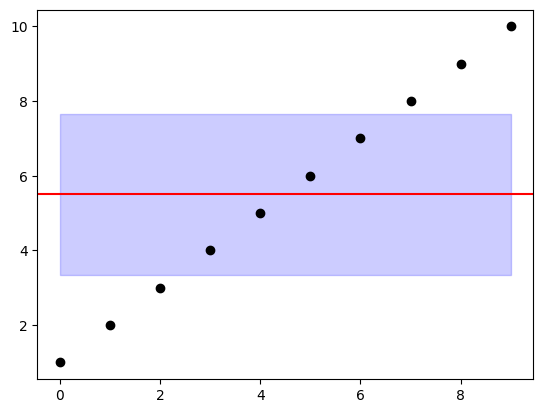

In [5]:
# Plot the CI intervals

# Create a figure and a subplot
fig, ax = plt.subplots()

# Plot the mean as a red line
ax.axhline(mean, color='red')

# Plot the confidence interval as a blue band
ax.fill_between(range(len(data)), confidence_interval[0], confidence_interval[1], color='blue', alpha=0.2)

# Plot the data points
ax.plot(data, 'ko')

# Show the plot
plt.show()

In [6]:
# Trying to use whole dataframe without it crashing
# cust_behav = dd.read_csv('/kaggle/input/ecommerce-behavior-data-from-multi-category-store/2019-Oct.csv')

In [7]:
# Let us use some more realistic data from e-commerce store (which is what TikTok article referenced as well as similar to current Stitch Fix biz model - Freestyle)
# cust_behav = pd.read_csv('/kaggle/input/ecommerce-behavior-data-from-multi-category-store/2019-Oct.csv')
# cust_behav

In [8]:
# cust_behav['event_type'].value_counts(normalize=True)

In [9]:
# %%timeit

# cust_behav2 = pd.read_csv('/kaggle/input/ecommerce-behavior-data-from-multi-category-store/2019-Nov.csv')
# cust_behav2

In [10]:
# Will reduce the dataset to 80% and see if notebook crashes
# cb_sample = cust_behav.sample(frac=0.50)

In [11]:
# Saved sample set to make loading data faster
cb_sample = pd.read_csv('/kaggle/input/e-commerce-event-data/cb_sample.csv')
cb_sample

,Unnamed: 0,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,40314660,2019-10-30 07:37:25 UTC,view,13901154,2053013557343158789,construction.components.faucet,genebre,127.96,527374947,1c147519-8b26-4aa0-bc78-b593fb16ae87
1,2338187,2019-10-02 18:32:55 UTC,view,4801946,2053013554658804075,electronics.audio.headphone,apple,25.45,525642970,7e7b0311-0a76-4888-b915-6c2a240b67bb
2,5052611,2019-10-05 03:05:49 UTC,view,2300244,2053013560530830019,electronics.camera.video,sjcam,213.56,554631275,7c3b8b60-d7fa-4c9c-87b0-6b2f753d8807
3,3182699,2019-10-03 15:11:16 UTC,view,4802587,2053013554658804075,electronics.audio.headphone,ergo,6.41,519968351,1629fd4b-1669-48e7-876b-ac3a9676d8d8
4,27866997,2019-10-21 02:28:29 UTC,view,1003304,2053013555631882655,electronics.smartphone,apple,577.66,519451311,4aa7ae59-de22-4411-aadf-d69ef2b11e82
...,...,...,...,...,...,...,...,...,...,...
21224377,21315512,2019-10-16 13:13:16 UTC,view,12703516,2053013553559896355,NaN,continental,157.53,521388327,ed112838-018a-47fb-9f48-687e6c0b99d4
21224378,14281888,2019-10-11 20:24:27 UTC,view,1004250,2053013555631882655,electronics.smartphone,apple,814.64,514341869,d50e86d9-8871-4562-ae97-332069f43a06
21224379,906055,2019-10-01 15:59:23 UTC,view,22800104,2053013560463721151,NaN,weifeng,16.73,544992104,a95ef75f-055a-4943-91d9-d50ad09941ef
21224380,11580434,2019-10-10 02:12:26 UTC,view,1004834,2053013555631882655,electronics.smartphone,samsung,170.92,545294859,fd44937e-b3d3-4d15-b441-4410c564eda0


In [12]:
# Choosing to use dataset with even number of users. 
# Event-level data so massive dataset with 42 million rows. 
# Let us explore the data a bit more to see right now how much it can be used for interview q's as well as for practical app of article

query = """
select count(distinct user_id) as unique_users
from cb_sample
"""

duckdb.query(query).df()

,unique_users
0,2531962


In [13]:
query = """
select event_type
, count(*) as total
from cb_sample
group by 1
order by 2 desc
"""

duckdb.query(query).df() # Typical funnel (inverted triangle)

,event_type,total
0,view,20389114
1,cart,463911
2,purchase,371357


In [14]:
cb_sample['event_type'].value_counts(normalize=True) # Great. The proportion of events is same from sample to original dataset

event_type
view        0.960646
cart        0.021857
purchase    0.017497
Name: proportion, dtype: float64

In [15]:
# Need to create user table with experient group assignment. Then join this to event table

query = """
select distinct user_id
from cb_sample
"""

users = duckdb.query(query).df()
len(users)

2531962

In [16]:
# Number of users is uneven. so need to get rid of one user
query = """
select user_id
, count(*)
from cb_sample
group by 1
order by 2 asc
"""

duckdb.query(query).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,user_id,count_star()
0,520932432,1
1,539973712,1
2,515732150,1
3,549607746,1
4,561477882,1
...,...,...
2531957,512505687,1413
2531958,513021392,1458
2531959,526731152,1466
2531960,512365995,1975


In [17]:
# Creating even number of users.
# USER_ID MAY NEED TO BE MODIFIED DUE TO RANDOM SAMPLING 

# query = """
# select distinct user_id
# from cb_sample
# where user_id != 537261383
# """

# users = duckdb.query(query).df()
# len(users)

In [18]:
# Create list of even amont of ctl and test labels, randomize the labels and append to users table

half_length = len(users) // 2
experiment_group = ['control'] * half_length + ['test'] * half_length
np.random.shuffle(experiment_group)
users['experiment_group'] = experiment_group

In [19]:
query = """
select experiment_group
, count(*) as count
from users
group by 1
"""

duckdb.query(query).df()

,experiment_group,count
0,test,1265981
1,control,1265981


In [20]:
# join users table to event table
query = """
select *
from users u
join cb_sample scb
on u.user_id = scb.user_id
"""

df = duckdb.query(query).df()
len(df) == len(cb_sample)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

True

In [21]:
query = """
select experiment_group
, user_id
, sum(case when event_type='view' then 1 else 0 end) as total_views
, sum(case when event_type='cart'then 1 else 0 end) as total_cart
, sum(case when event_type='purchase'then 1 else 0 end) as total_purchase
from df
group by 1,2
"""

events_agg = duckdb.query(query).df()
events_agg

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,experiment_group,user_id,total_views,total_cart,total_purchase
0,control,516266655,73.0,1.0,0.0
1,control,557130803,12.0,0.0,0.0
2,test,518418918,8.0,0.0,0.0
3,control,541340268,90.0,0.0,1.0
4,test,531595195,19.0,0.0,0.0
...,...,...,...,...,...
2531957,test,545118917,1.0,0.0,0.0
2531958,test,540455717,1.0,0.0,0.0
2531959,control,561887937,1.0,0.0,0.0
2531960,test,516937884,1.0,0.0,0.0


In [22]:
# Split between experiment groups
query = """
select *
from events_agg
where experiment_group = 'control'
"""

ctl_events_agg = duckdb.query(query).df()

query = """
select *
from events_agg
where experiment_group = 'test'
"""

test_events_agg = duckdb.query(query).df()

### Checking Distributions for Control and Experiment Groups

In [23]:
def is_normal(data):
    stat, p = shapiro(data)
    alpha = 0.05
    if p > alpha:
        return 'Sample looks Gaussian (fail to reject H0)'
    else:
        return 'Sample does not look Gaussian (reject H0)'

In [24]:
# only get events columns
event_cols = ctl_events_agg[['total_views', 'total_cart', 'total_purchase']]
event_cols

,total_views,total_cart,total_purchase
0,73.0,1.0,0.0
1,12.0,0.0,0.0
2,90.0,0.0,1.0
3,9.0,0.0,0.0
4,315.0,1.0,0.0
...,...,...,...
1265976,1.0,0.0,0.0
1265977,1.0,0.0,0.0
1265978,1.0,0.0,0.0
1265979,1.0,0.0,0.0


In [25]:
for i in range(0,len(list(event_cols))):
    
    col = list(event_cols)[i]
    
    print('Control', col, 'Distribution:', is_normal(ctl_events_agg[col]))

    print('Test', col, 'Distribution:',is_normal(test_events_agg[col]))

/opt/conda/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Control total_views Distribution: Sample does not look Gaussian (reject H0)
Test total_views Distribution: Sample does not look Gaussian (reject H0)
Control total_cart Distribution: Sample does not look Gaussian (reject H0)
Test total_cart Distribution: Sample does not look Gaussian (reject H0)
Control total_purchase Distribution: Sample does not look Gaussian (reject H0)
Test total_purchase Distribution: Sample does not look Gaussian (reject H0)


None of the distributions are normal. So cannot use the t-test for statistical significance.

### First Quick Pass of CI on One Experiment Test Group's Behavior Metric

The confidence interval is: (8.020527752307201, 8.081221010114986)


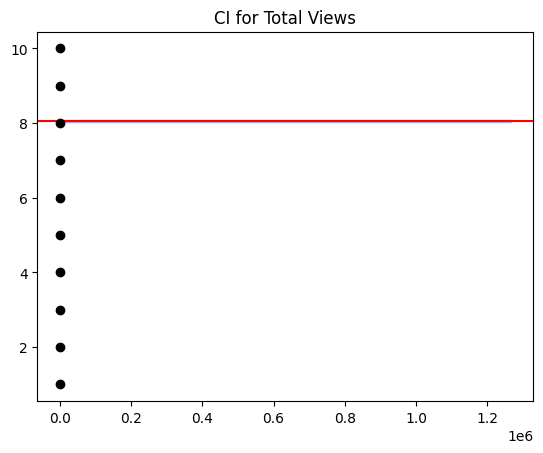

In [26]:
# Create confidence interval with the new data (Ctl group's views)

# Let's assume you have some data in a Python list
ctl_user_views = ctl_events_agg['total_views']

# Calculate the mean and standard error
mean = np.mean(ctl_user_views)
standard_error = scipy.stats.sem(ctl_user_views)

# Define the confidence level to be 95%
confidence_level = 0.95

# Calculate the confidence interval
confidence_interval = scipy.stats.t.interval(confidence_level, len(ctl_user_views)-1, loc=mean, scale=standard_error)

print(f"The confidence interval is: {confidence_interval}")

# Plot the CI intervals

# Create a figure and a subplot
fig, ax = plt.subplots()

# Plot the mean as a red line
ax.axhline(mean, color='red')

# Plot the confidence interval as a blue band
ax.fill_between(range(len(ctl_user_views)), confidence_interval[0], confidence_interval[1], color='blue', alpha=0.2)

# Plot the data points
ax.plot(data, 'ko')

# Show the plot
plt.title("CI for Total Views")
plt.show()

# Statistical Testing Methods

## User Average Metrics
### Distributions are non-normal --> Use Mann Whitney U Test

In [27]:
# Now let us aggregate data at randomization unit to build CI interval
# Simulating real biz A/B test data

# Calculate avg views/carts/purchase per user for each experiment group
query = """
select experiment_group
, event_time[:10] as date
, sum(case when event_type = 'view' then 1 else 0 end)/count(distinct user_id) as views_per_user
, sum(case when event_type = 'cart' then 1 else 0 end)/count(distinct user_id) as carts_per_user
, sum(case when event_type = 'purchase' then 1 else 0 end)/count(distinct user_id) as purchases_per_user
from df
group by 1,2
"""

user_avg_metric = duckdb.query(query).df()
user_avg_metric

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,experiment_group,date,views_per_user,carts_per_user,purchases_per_user
0,control,2019-10-07,3.862376,0.057876,0.071901
1,test,2019-10-30,3.817393,0.057048,0.069308
2,test,2019-10-18,3.855881,0.110197,0.070408
3,control,2019-10-08,3.771505,0.051163,0.064618
4,control,2019-10-24,3.810253,0.110217,0.074383
...,...,...,...,...,...
57,test,2019-10-01,3.941837,0.056080,0.063228
58,test,2019-10-29,3.874167,0.057153,0.064859
59,control,2019-10-04,3.953875,0.126661,0.078547
60,control,2019-10-23,3.773388,0.103972,0.072236


In [28]:
control = duckdb.query("select * from user_avg_metric where experiment_group = 'control'").df()
test = duckdb.query("select * from user_avg_metric where experiment_group = 'test'").df()

In [29]:
# Metrics are skewed so using Mann Whitney U test to determine statistical significance

def run_mann_whitney_u_test(df1, df2, col):
    # Extract the two data samples
    data1 = df1[col]
    data2 = df2[col]

    # Perform the Mann-Whitney U test
    stat, p = mannwhitneyu(data1, data2)

    alpha = 0.05
    if p<alpha:
        print("We can reject Ho in favor of Ha. Therefore there is statistical significant difference between experiment groups in favor of treatment group.")
    else:
        print("We do not have enough evidence to reject Ho. Therefore, there is no significant statistical difference between two experiment groups' metric of interest.")

columns = list(user_avg_metric)[2:]
for c in columns:
    print('Metric:', c)
    run_mann_whitney_u_test(control, test, c)

Metric: views_per_user
We do not have enough evidence to reject Ho. Therefore, there is no significant statistical difference between two experiment groups' metric of interest.
Metric: carts_per_user
We do not have enough evidence to reject Ho. Therefore, there is no significant statistical difference between two experiment groups' metric of interest.
Metric: purchases_per_user
We do not have enough evidence to reject Ho. Therefore, there is no significant statistical difference between two experiment groups' metric of interest.


___

In [30]:
# Click Through Rate using Mann Whitney U Test
# TESTING- very small dataset

control = pd.read_csv('/kaggle/input/example-dataset-for-ab-test/control_group.csv', sep=';')
test = pd.read_csv('/kaggle/input/example-dataset-for-ab-test/test_group.csv', sep=';')

In [31]:
#Convert date to datetime
control['Date'] = pd.to_datetime(control['Date'], format = '%d.%m.%Y')
test['Date'] = pd.to_datetime(test['Date'], format = '%d.%m.%Y')

#Fill missing values with mean
control = round(control.fillna(control.mean(numeric_only=True)))

#Concat both dataframes
data = pd.concat([control, test], axis =0)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 0 to 29
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Campaign Name        60 non-null     object        
 1   Date                 60 non-null     datetime64[ns]
 2   Spend [USD]          60 non-null     int64         
 3   # of Impressions     60 non-null     float64       
 4   Reach                60 non-null     float64       
 5   # of Website Clicks  60 non-null     float64       
 6   # of Searches        60 non-null     float64       
 7   # of View Content    60 non-null     float64       
 8   # of Add to Cart     60 non-null     float64       
 9   # of Purchase        60 non-null     float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 5.2+ KB


In [32]:
data.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,2019-08-01,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2019-08-02,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,2019-08-03,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,2019-08-04,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,2019-08-05,1835,109560.0,88845.0,5321.0,2221.0,1944.0,1300.0,523.0


In [33]:
data['CTR'] = round((data['# of Website Clicks']/ data['# of Impressions']), 2)

ctr = data.groupby(['Campaign Name', 'Date'])['CTR'].mean().to_frame()

#Create a pivot table
ctr_pivot= ctr.pivot_table(columns= 'Campaign Name', index='Date', 
values = 'CTR')

In [34]:
data.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase,CTR
0,Control Campaign,2019-08-01,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0,0.08
1,Control Campaign,2019-08-02,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0,0.07
2,Control Campaign,2019-08-03,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0,0.05
3,Control Campaign,2019-08-04,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0,0.04
4,Control Campaign,2019-08-05,1835,109560.0,88845.0,5321.0,2221.0,1944.0,1300.0,523.0,0.05


In [35]:
ctr_pivot[:5]

Campaign Name,Control Campaign,Test Campaign
Date,,
2019-08-01,0.08,0.08
2019-08-02,0.07,0.05
2019-08-03,0.05,0.11
2019-08-04,0.04,0.05
2019-08-05,0.05,0.05


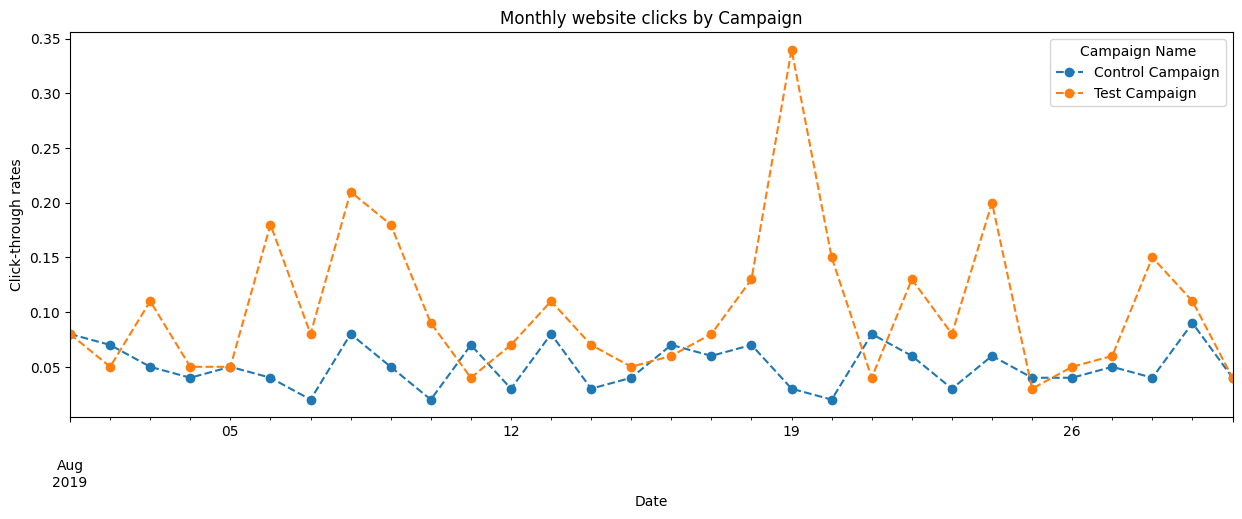

In [36]:
#Plot the data as a line plot
ctr_pivot.plot(kind='line', figsize=(15, 5), style='o--', markersize=6)

#add title and axis labels
plt.title('Monthly website clicks by Campaign')
plt.xlabel('Date') # output is not right
plt.ylabel('Click-through rates')
plt.show()

In [37]:
!pip install pingouin --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-cv 0.8.2 requires keras-core, which is not installed.
keras-nlp 0.8.1 requires keras-core, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
google-cloud-bigquery 2.34.4 requires packaging<22.0dev,>=14.3, but you have packaging 23.2 which is incompatible.
jupyterlab 4.1.2 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.0.3 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
osmnx 1.9.1 requires shapely>=2.0, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.0 requires shapely>=

In [38]:
# Create a DatFrame with two columns Campaign name and CTR
df_test = data[['Campaign Name', 'CTR']]

# Reshape the DataFrame to a wide format
df_wide = df_test.pivot(columns = 'Campaign Name', values='CTR')

import pingouin as pg

# Conduct a Mann-Whitney U test
test_results = pg.mwu(x=df_wide['Test Campaign'],
y=df_wide['Control Campaign'], alternative='greater')

print(test_results)

     U-val alternative     p-val       RBC      CLES
MWU  699.0     greater  0.000109 -0.553333  0.776667


In [39]:
df_test[:5]

,Campaign Name,CTR
0,Control Campaign,0.08
1,Control Campaign,0.07
2,Control Campaign,0.05
3,Control Campaign,0.04
4,Control Campaign,0.05


In [40]:
df_wide[:5]

Campaign Name,Control Campaign,Test Campaign
0,0.08,0.08
1,0.07,0.05
2,0.05,0.11
3,0.04,0.05
4,0.05,0.05


___

In [41]:
# Each row is for a different day and this is what is fed into the statistical test. So original attempt before test is right! :)

# Now, need to make sure that we are thinking about straight metrics calculation, hypothesis testing with correct stat test to t-statistic to p-value to population PDF correctly to answer question 
# of whether or not Ho is rejectable or not. 
# Through original data inferring pop density mean with stat test to RJ Ho or not?

* Statistical test is needed to determine whether or not data that is provided/more extreme data would come from scenario in which Ho == True
* test statistic: 

    * The test statistic is a numerical value calculated from sample data during a statistical hypothesis test.
    * It quantifies the **distance** between the observed sample data and what we would expect under the null hypothesis.
    * In essence, the test statistic summarizes how far our data deviates from the null hypothesis.
Common examples of test statistics include the t-value, z-score, and F-statistic.
    * The choice of test statistic depends on the type of test (e.g., t-tests, ANOVA, chi-square tests).
* p-value:
    * The p-value (probability value) is a crucial component in hypothesis testing.
    * It represents the probability of obtaining the observed test statistic (or more extreme values) if the null hypothesis were true.
    * A small p-value indicates that the observed data is unlikely to occur by chance alone under the null hypothesis.
    * Conversely, a large p-value suggests that the observed data could reasonably occur even if the null hypothesis were true.
    * Researchers typically compare the p-value to a predefined significance level (often 0.05) to make decisions about rejecting or failing to reject the null hypothesis.
    
Relationship:
The test statistic and p-value are intimately connected:
* The test statistic provides the raw information (e.g., t-value, z-score) about the sample data.
* The p-value is derived from the test statistic and tells us how consistent the data is with the null hypothesis.

The p-value is calculated based on the distribution of the test statistic under the null hypothesis.
* If the p-value is small (typically less than 0.05), we reject the null hypothesis.
* If the p-value is large, we fail to reject the null hypothesis.

Interpretation:
* Test Statistic: It’s a measure of the observed difference or effect.
* P-Value: It’s a measure of the evidence against the null hypothesis.

PDF/Probability Distribution Function:
* Graphically, the test statistic corresponds to a specific point on the probability distribution function (PDF) associated with that test.
* The PDF provides the context for interpreting the test statistic.
* Different tests (e.g., t-tests, F-tests, chi-square tests) have their own corresponding distributions (e.g., t-distribution, F-distribution, chi-square distribution).
* For example, in a t-test, the test statistic is the t-value, and its distribution is the t-distribution.

    * p-value Representation:
        * The p-value is a function of the chosen test statistic and is therefore a random variable.
        * When we run a hypothesis test, we calculate the p-value based on the observed test statistic.
        * Graphically, the p-value corresponds to an area in the tail of the relevant probability distribution.

        Specifically:
        * For a one-tailed test, the p-value is the area to the right of the test statistic.
        * For a two-tailed test, the p-value is the combined area to the left and right of the test statistic.
        * When the null hypothesis is true, the p-value follows a uniform distribution between 0 and 1.

Statistical Power:
* Statistical power is the probability that a hypothesis test can detect an effect in a sample when that effect truly exists in the population.
* It represents the sensitivity of a test to detect specific effects.
* In other words, how likely is the test to correctly identify an effect if it’s genuinely present?
* Researchers typically aim for a statistical power of 80% or higher
* Higher test statistics (farther from the null hypothesis) contribute to greater statistical power.
* A larger test statistic increases the chances of correctly detecting an effect.
* High power means a lower probability of making a Type II error (failing to detect a true effect).

High power is desirable for several reasons:

* Minimizing Type II Errors: High power reduces the risk of missing important effects. It ensures that we correctly identify real differences or relationships.
* Efficient Resource Use: Adequate power allows researchers to detect effects with smaller sample sizes, saving time and resources.

## User-level Conversion Metrics

In [42]:
# User events aggregated
events_agg

,experiment_group,user_id,total_views,total_cart,total_purchase
0,control,516266655,73.0,1.0,0.0
1,control,557130803,12.0,0.0,0.0
2,test,518418918,8.0,0.0,0.0
3,control,541340268,90.0,0.0,1.0
4,test,531595195,19.0,0.0,0.0
...,...,...,...,...,...
2531957,test,545118917,1.0,0.0,0.0
2531958,test,540455717,1.0,0.0,0.0
2531959,control,561887937,1.0,0.0,0.0
2531960,test,516937884,1.0,0.0,0.0


In [43]:
# Need to make a new column to change user as either making a purchase (at least one) -> 1 or not -> 0.
user_conversion = duckdb.query("select *, case when total_purchase >1 then 1 else 0 end as conversion from events_agg").df()
user_conversion.head()

,experiment_group,user_id,total_views,total_cart,total_purchase,conversion
0,control,516266655,73.0,1.0,0.0,0
1,control,557130803,12.0,0.0,0.0,0
2,test,518418918,8.0,0.0,0.0,0
3,control,541340268,90.0,0.0,1.0,0
4,test,531595195,19.0,0.0,0.0,0


In [44]:
user_conversion.head(2)

,experiment_group,user_id,total_views,total_cart,total_purchase,conversion
0,control,516266655,73.0,1.0,0.0,0
1,control,557130803,12.0,0.0,0.0,0


In [45]:
# Convert or not by Experiment Group
duckdb.query("select experiment_group, round(sum(conversion)/count(distinct user_id)*100,2) as percent_converted from user_conversion group by experiment_group").df()

,experiment_group,percent_converted
0,control,2.48
1,test,2.49


In [46]:
# Some other helpful statistics
conversion_rates = user_conversion.groupby('experiment_group')['conversion']

std_p = lambda x: np.std(x, ddof=0)
se_p = lambda x: stats.sem(x, ddof=0) #measure of how much a sample's mean might differ from the population mean

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']
conversion_rates

/tmp/ipykernel_18/3233805808.py:7: FutureWarning: The provided callable <function mean at 0x7eb0e020c3a0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])


,conversion_rate,std_deviation,std_error
experiment_group,,,
control,0.024841,0.155640,0.000138
test,0.024852,0.155674,0.000138


Looks like both groups performed similarly with control winning by a bit: 2.49% versus 2.48%.

/tmp/ipykernel_18/1853647684.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(x = user_conversion['experiment_group'], y=user_conversion['conversion'], ci=False)


Text(0, 0.5, 'Converted Proportion')

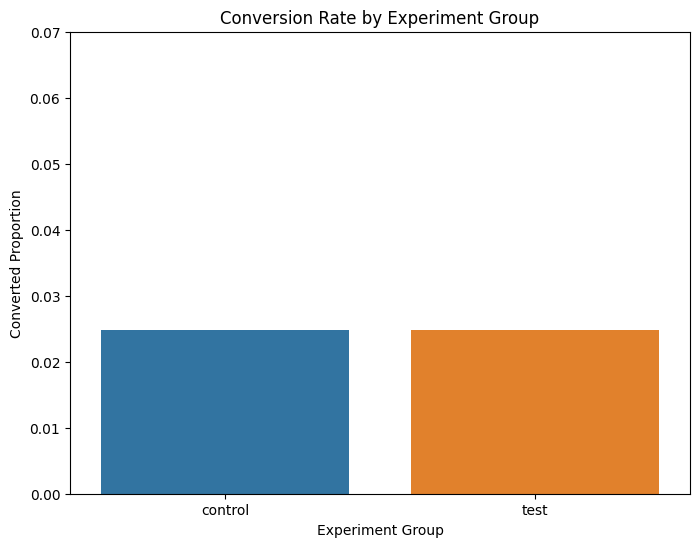

In [47]:
plt.figure(figsize=(8,6))

sns.barplot(x = user_conversion['experiment_group'], y=user_conversion['conversion'], ci=False)

plt.ylim(0, 0.07)
plt.title('Conversion Rate by Experiment Group')
plt.xlabel('Experiment Group')
plt.ylabel('Converted Proportion')

In [48]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

#get the target metric column
control_results = user_conversion[user_conversion['experiment_group'] == 'control']['conversion']
treatment_results = user_conversion[user_conversion['experiment_group'] == 'test']['conversion']

In [49]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.06
p-value: 0.955
ci 95% for control group: [0.025, 0.025]
ci 95% for treatment group: [0.025, 0.025]


Both control and test CI's are the same and so overlap. There is no difference between the two. Also, the p-value is not below alpha = 0.05. So would fail to reject Ho.

## Event-level Conversion Metrics

In [50]:
df.head()

,user_id,experiment_group,Unnamed: 0,event_time,event_type,product_id,category_id,category_code,brand,price,user_id_1,user_session
0,525642970,test,2338187,2019-10-02 18:32:55 UTC,view,4801946,2053013554658804075,electronics.audio.headphone,apple,25.45,525642970,7e7b0311-0a76-4888-b915-6c2a240b67bb
1,554631275,test,5052611,2019-10-05 03:05:49 UTC,view,2300244,2053013560530830019,electronics.camera.video,sjcam,213.56,554631275,7c3b8b60-d7fa-4c9c-87b0-6b2f753d8807
2,519968351,test,3182699,2019-10-03 15:11:16 UTC,view,4802587,2053013554658804075,electronics.audio.headphone,ergo,6.41,519968351,1629fd4b-1669-48e7-876b-ac3a9676d8d8
3,519451311,control,27866997,2019-10-21 02:28:29 UTC,view,1003304,2053013555631882655,electronics.smartphone,apple,577.66,519451311,4aa7ae59-de22-4411-aadf-d69ef2b11e82
4,514229043,control,13483574,2019-10-11 10:32:00 UTC,view,17302619,2053013553853497655,None,chanel,197.02,514229043,c3153441-6b7d-4c57-992b-4efe52de5fdc


In [51]:
# CTR
query = """
select experiment_group
, user_id
, IFNULL(sum(case when event_type = 'cart' then 1 else 0 end)*1.0/sum(case when event_type = 'view' then 1 else 0 end),0) as cart_rate
, sum(case when event_type = 'purchase' then 1 else 0 end)*1.0/sum(case when event_type = 'cart' then 1 else 0 end) as purchase_rate
from df
group by 1,2
"""

user_rates = duckdb.query(query).df()
user_rates

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,experiment_group,user_id,cart_rate,purchase_rate
0,control,549060054,0.333333,1.25
1,test,515331054,0.000000,NaN
2,control,520244173,0.054545,1.00
3,test,554269012,0.142857,0.00
4,control,513583073,0.000000,NaN
...,...,...,...,...
2531957,control,517477743,0.000000,NaN
2531958,test,560554004,0.000000,NaN
2531959,control,551262457,0.000000,NaN
2531960,control,565676309,0.000000,NaN


In [52]:
# what is causing NaN:
# see what is in view, cart and purchase for couple of users creating NaN
# hopefully all scenarios represented, 0 num/denom or both
# is * 1.0 in numerator needed?

# cart_rate = carts/views
# purchase_rate = purchases/carts

# 229: cart_rate: 1/0 = NaN 
# 368: cart_rate: 0/1= 0.0, purchase_rate: 0/0= NaN
# 978: cart_rate: 0/1= 0.0, purchase_rate: 0/0= NaN
# 073: cart_rate: 0/1= 0.0, purchase_rate: 0/0= NaN
        
# Division by 0 as denom or num and denom causes NaN 
# Division with 0 as numerator causes 0.0
duckdb.query('select user_id, event_type from df where user_id in (557234978, 557125368, 559113073, 555550229) order by user_id').df()

,user_id,event_type
0,555550229,cart
1,557125368,view
2,557125368,view
3,557125368,view
4,557125368,view
5,557125368,view
6,557234978,view
7,557234978,view
8,557234978,view
9,557234978,view


In [53]:
# percentage of non-NaN cart/purchase rates
len(duckdb.query('select * from user_rates where cart_rate is NOT NULL AND purchase_rate IS NOT NULL').df())/len(user_rates)

0.09140658509092948

In [54]:
user_rates2 = duckdb.query('select * from user_rates where cart_rate is NOT NULL AND purchase_rate IS NOT NULL').df()

In [55]:
user_rates2

,experiment_group,user_id,cart_rate,purchase_rate
0,control,549060054,0.333333,1.25
1,control,520244173,0.054545,1.00
2,test,554269012,0.142857,0.00
3,test,551725843,0.001433,1.00
4,control,513018474,0.019231,0.00
...,...,...,...,...
231433,test,556673438,0.000000,0.00
231434,test,541350880,0.000000,0.00
231435,test,545923885,0.000000,0.00
231436,test,540754488,0.000000,0.00


In [56]:
user_rates2

,experiment_group,user_id,cart_rate,purchase_rate
0,control,549060054,0.333333,1.25
1,control,520244173,0.054545,1.00
2,test,554269012,0.142857,0.00
3,test,551725843,0.001433,1.00
4,control,513018474,0.019231,0.00
...,...,...,...,...
231433,test,556673438,0.000000,0.00
231434,test,541350880,0.000000,0.00
231435,test,545923885,0.000000,0.00
231436,test,540754488,0.000000,0.00
